In [10]:
from typing import Callable, Tuple, Iterator, Any

from abc import abstractmethod
from functools import partial
import dataclasses

import pickle
import tqdm
import optax
import diffrax as dfx
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from check_shapes import check_shape, check_shapes

import neural_diffusion_processes as ndp
from neural_diffusion_processes.types import Array


from jax.config import config


config.update("jax_enable_x64", True)

In [11]:
LOGS_DIR = f'logs'
DATETIME_STR = datetime.datetime.now().strftime("%b%d_%H%M%S")
TRAIN = True

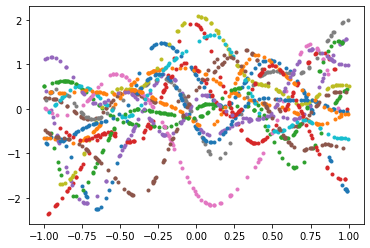

In [12]:
@dataclasses.dataclass(frozen=True)
class Config:
    seed = 42
    batch_size = 16
    num_steps = 50_000

    num_bidim_attention_layers=2
    hidden_dim=16
    num_heads=4



@jax.tree_util.register_pytree_node_class
@dataclasses.dataclass(frozen=True)
class DataBatch:
    function_inputs: Array
    function_outputs: Array

    @check_shapes()
    def __post_init__(self) -> None:
        check_shape(self.function_inputs, "[batch, num_points, input_dim]")
        check_shape(self.function_outputs, "[batch, num_points, output_dim]")

    def tree_flatten(self):
        children = (self.function_inputs, self.function_outputs)
        aux_data = None
        return (children, aux_data)

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        del aux_data
        return cls(*children)


def get_gp_data(key, kernel, num_samples: int, *, x_range=(-1., 1.), num_points: int = 100, input_dim: int = 1, output_dim:int = 1):
    """
    Returns tuple of inputs and outputs. The outputs are drawn from a GP prior with a fixed kernel.
    """
    assert input_dim == 1
    assert output_dim == 1

    def sample_single(key):
        input_key, output_key = jax.random.split(key, 2)
        x = jax.random.uniform(input_key, [num_points, 1], minval=x_range[0], maxval=x_range[1], dtype=jnp.float64)
        x = x.sort(axis=0)
        y = ndp.misc.sample_mvn(output_key, jnp.zeros_like(x), kernel(x))
        return x, y
    
    x, y = jax.vmap(sample_single)(jax.random.split(key, num_samples))
    return x, y


@check_shapes(
    "data[0]: [len_data, num_points, input_dim]",
    "data[1]: [len_data, num_points, output_dim]",
)
def dataloader(data: Tuple[Array, Array], batch_size: int, *, key) -> Iterator[DataBatch]:
    """Yields minibatches of size `batch_size` from the data."""
    x, y = data
    dataset_size = len(x)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jax.random.permutation(key, indices)
        (key,) = jax.random.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield DataBatch(function_inputs=x[batch_perm], function_outputs=y[batch_perm])
            start = end
            end = start + batch_size


key = jax.random.PRNGKey(Config.seed)
k0 = ndp.kernels.SquaredExpontialKernel(lengthscale=.2)

key, *dataset_keys = jax.random.split(key, 3)
data = get_gp_data(dataset_keys[0], k0, 1_000)
dataset = dataloader(data, Config.batch_size, key=dataset_keys[1])
batch = next(dataset)
plt.plot(batch.function_inputs[..., 0].T, batch.function_outputs[..., 0].T, '.')
plt.show()



In [13]:
class PreConditionedScoreNetwork(Callable):
    r"""Score preconditioned by the gram matrix: K \nable_y p_t(y(x))."""

    @abstractmethod
    @check_shapes(
        "t: []",
        "yt: [num_points, output_dim]",
        "x: [num_points, input_dim]",
        "return: [num_points, output_dim]",
    )
    def __call__(self, t: Array, yt: Array, x: Array) -> Array:
        pass


class SDE:

    def __init__(self, limiting_kernel, beta_schedule):
        self.limiting_kernel = limiting_kernel
        self.limiting_mean_fn = lambda x: jnp.zeros_like(x[..., :1])
        self.beta_schedule = beta_schedule

        if not isinstance(self.limiting_kernel, ndp.kernels.WhiteKernel):
            raise NotImplementedError("Code assumes diag pt covariance (i.e. k1 is a WhiteKernel)")

    @check_shapes(
        "t: []",
        "y0: [num_points, 1]",
        "x: [num_points, 1]",
        "return[0]: [num_points, 1]",
        "return[1]: [num_points, num_points] if full_cov",
        "return[1]: [num_points, 1] if not full_cov",
    )
    def pt(self, t, y0, x, full_cov: bool):
        mean_coef = jnp.exp(-0.5 * self.beta_schedule.B(t))
        mean = mean_coef * y0 + (1.0 - mean_coef) * self.limiting_mean_fn(x)
        cov = (1.0 -  jnp.exp(-self.beta_schedule.B(t))) * k1(x)
        if full_cov:
            return mean, cov
        else:
            return mean, jnp.diag(cov)[..., None]

    @check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
    def drift(self, t, yt, x):
        return  - 0.5 * self.beta_schedule(t) * (yt - self.limiting_mean_fn(x)) # [N, 1]

    @check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, N]",)
    def diffusion(self, t, yt, x):
        del yt
        sqrt_K = jnp.linalg.cholesky(self.limiting_kernel(x) + 1e-12 * jnp.eye(len(x)))
        return jnp.sqrt(beta_schedule(t)) * sqrt_K

    @check_shapes(
        "t: []",
        "y: [num_points, output_dim]",
        "x: [num_points, input_dim]",
        "return: []"
    )
    def loss(
        self,
        key,
        t: Array,
        y: Array,
        x: Array,
        preconditioned_score: PreConditionedScoreNetwork,
    ):
        mean, cov = self.pt(t, y, x, full_cov=False)
        
        key, eps_key = jax.random.split(key)
        eps = jax.random.normal(eps_key, mean.shape)
        yt = mean + jnp.sqrt(cov) * eps

        precond_score_pt = preconditioned_score(t, yt, x)

        # weight = (1.0 -  jnp.exp(-0.5 * beta_schedule.B(t))) ** -1

        objective = eps / jnp.sqrt(cov)
        return jnp.mean(jnp.sum((objective - precond_score_pt)**2, -1), -1)



def loss(sde: SDE, preconditioned_score: Callable[..., Any], params: hk.Params, batch: DataBatch, key):
    batch_size = len(batch.function_inputs)
    t0 = beta_schedule.t0
    t1 = beta_schedule.t1

    key, tkey = jax.random.split(key)
    # Low-discrepancy sampling over t to reduce variance
    t = jax.random.uniform(tkey, (batch_size,), minval=t0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)

    @jax.vmap
    def _loss(key, t, y, x):
        key, network_key = jax.random.split(key)
        # Network awkwardly requires a batch dimension for the inputs
        score_network = lambda t, yt, x: preconditioned_score(params, network_key, x[None], yt[None], t[None])[0]
        return sde.loss(key, t, y, x, score_network)

    keys = jax.random.split(key, batch_size)
    error = _loss(keys, t, batch.function_outputs, batch.function_inputs)
    return jnp.mean(error)



k1 = ndp.kernels.WhiteKernel()
beta_schedule = ndp.sde.LinearBetaSchedule()
mean_function = lambda x: jnp.zeros_like(x[..., :1])

sde = SDE(limiting_kernel=k1, beta_schedule=beta_schedule)

In [14]:


@hk.transform
def precond_score_network(x, y, t):
    model = ndp.models.attention.BiDimensionalAttentionModel(
        num_bidim_attention_layers=Config.num_bidim_attention_layers,
        hidden_dim=Config.hidden_dim,
        num_heads=Config.num_heads,
    )
    return model(x, y, t)
        

key, model_init_key = jax.random.split(key)
params = precond_score_network.init(
    rng=model_init_key,
    x=batch.function_inputs,
    y=batch.function_outputs,
    t=jnp.ones([len(batch.function_inputs)])
)

loss(sde, precond_score_network.apply, params, batch, key)

Array(7.64009618, dtype=float64)

loss 10.41: 100%|██████████| 50000/50000 [06:16<00:00, 132.94it/s]


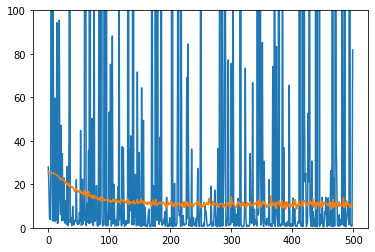

In [15]:
def fit(key, model, params: hk.Params, optimizer: optax.GradientTransformation) -> hk.Params:
    metrics = []
    opt_state = optimizer.init(params)
    loss_fixed_fn = jax.jit(
        lambda params: loss(sde, model, params, batch, key)
    )

    @jax.jit
    def step(params, opt_state, batch, key):
        loss_value, grads = jax.value_and_grad(partial(loss, sde, model))(params, batch, key)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    progress_bar = tqdm.tqdm(list(range(1, Config.num_steps + 1)), miniters=1)

    for i in progress_bar:
        batch = next(dataset)
        key, subkey = jax.random.split(key)
        params, opt_state, loss_value = step(params, opt_state, batch, subkey)
        if i % 100 == 0:
            fixed_loss_value = loss_fixed_fn(params)
            progress_bar.set_description(f"loss {fixed_loss_value:.2f}")
            metrics.append({'loss': loss_value, 'fixed_loss': fixed_loss_value})

        track_loss(i, loss_value)

    return params, metrics



track_loss = ndp.training_utils.tensorboard_loss_tracker(
    log_directory=f"{LOGS_DIR}/tensorboards/{DATETIME_STR}")

learning_rate_schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=1e-3,
    warmup_steps=1000,
    decay_steps=10_000,
    end_value=1e-4
)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.scale_by_adam(),
    optax.scale_by_schedule(learning_rate_schedule),
    optax.scale(-1.0)
)


if TRAIN:
    opt_params, metrics = fit(key, precond_score_network.apply, params, optimizer)
    df = pd.DataFrame(metrics)
    path = f'{LOGS_DIR}/checkpoints/{DATETIME_STR}'
    ndp.training_utils.save_checkpoint(None, opt_params, path, step_index=Config.num_steps)
    plt.plot(df['loss'])
    plt.plot(df['fixed_loss'])
    plt.ylim(0, 100)

In [16]:

if TRAIN:
    eval_params = opt_params
else:
    path = f'{LOGS_DIR}/checkpoints/Feb04_182429/variables/step_100000.pickle'
    with open(path, "rb") as file:
        eval_params = pickle.load(file)

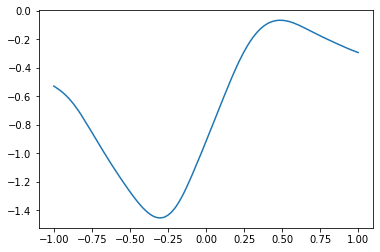

In [22]:

network = lambda t, yt, x: precond_score_network.apply(eval_params, key, x[None], yt[None], t[None])[0]


@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def reverse_drift_ode(t, yt, x):
    # covariance doesn't depend on y0
    _, cov = sde.pt(t, jnp.ones_like(yt) * jnp.nan, x, full_cov=False)
    weight = (1.0 -  jnp.exp(-0.5 * sde.beta_schedule.B(t))) ** -1
    score = - weight * cov * network(t, yt, x)
    return  sde.drift(t, yt, x) - 0.5 * sde.beta_schedule(t) * score  # [N, 1]

@check_shapes("t: []", "yt: [N, 1]", "x: [N, 1]", "return: [N, 1]",)
def reverse_drift_sde(t, yt, x):
    weight = (1.0 -  jnp.exp(-0.5 * sde.beta_schedule.B(t))) ** -1
    return  sde.drift(t, yt, x) + weight *  sde.beta_schedule(t) * network(t, yt, x) # [N, 1]

def reverse_solve(key, x, yT, prob_flow: bool = True):
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    ts = t1 + (t0 - t1) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)[::-1]
    saveat = dfx.SaveAt(ts=ts)
    # reverse time, solve from t1 to t0
    if prob_flow:
        terms = dfx.ODETerm(reverse_drift_ode)
    else:
        drift = dfx.ODETerm(reverse_drift_sde)
        shape = jax.ShapeDtypeStruct(yT.shape, yT.dtype)
        bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=1e-3 / 2., shape=shape, key=key)
        terms = dfx.MultiTerm(drift, dfx.ControlTerm(sde.diffusion, bm))

    return dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t1, t1=t0, dt0=-1e-3/2., y0=yT, saveat=saveat, args=x, adjoint=dfx.NoAdjoint())


key, *subkeys = jax.random.split(key, 3)
x_test = jnp.linspace(-1, 1, 500)[:, None]
yT = jax.random.normal(subkeys[0], x_test.shape)
out = reverse_solve(subkeys[1], x_test, yT)
plt.plot(x_test, out.ys[-1]);

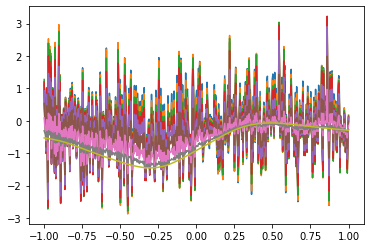

In [23]:
plt.plot(x_test, out.ys[..., 0].T);